# Analysis of AirBNB data from Boston
In this analysis, Boston AirBNB data from the listings.csv file downloaded from https://www.kaggle.com/airbnb/boston/data is analyzed according to the CRISP-DM process to answer some questions, mainly relevant for people offering their accommodations.

## 1. Business understanding
AirBNB is a community based platform in which users can offer their private accommodations to other people. So the platform acts as a kind of broker. Users can earn money by renting their couch, their room, their flats or even a complete houses. Its is assumed that one reason to book a specific accommodation is - beside location, price, and amenities - the rating by other users. Here, it shall be - amongst some other questions - analyzed whether there are aspects that renters can influence that are corrolated with a high review scores rating.

The following aspects are analyzed in 4. Modelling:
1. Is there correlation between price and review scores rating?
2. Are there differences in review scores rating and price between different neighbourhoods?
3. Is there correlation between number of reviews and review scores rating?
4. Is there a relation between amenities and review scores rating?
5. Is there a way to predict the review scores rating based on amenities and price?

## 2. Data understanding
The data is loaded and a number of things are checked to understand the dataset.

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

df = pd.read_csv('./listings.csv') # Read in data
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


### Determine the number of rows (entries for specifc accommodations) and columns (different features of the accommodations)

In [2]:
num_rows = df.shape[0] #Contains the number of rows in the dataset
num_cols = df.shape[1] #Contains the number of columns in the dataset

print('The dataset contains', num_rows, 'rows and', num_cols, 'columns.')

The dataset contains 3585 rows and 95 columns.


### Check of the columns to find out which are important for this analysis and check their status
The dataset contains many full text columns. They will not be considered here. It is assumed that neighborhood (the cleansed version), the property type, the room type, the accommodates, the amenities, the price, the availability, the number of reviews, and of course the rating score itself play a role to answer the business questions above.

In [3]:
no_nulls = set(df.columns[df.isnull().mean()==0]) # Check which columns are complete
print(no_nulls)

{'availability_30', 'host_thumbnail_url', 'host_total_listings_count', 'host_identity_verified', 'state', 'country_code', 'guests_included', 'room_type', 'neighbourhood_cleansed', 'host_url', 'host_has_profile_pic', 'require_guest_profile_picture', 'smart_location', 'amenities', 'host_picture_url', 'bed_type', 'host_is_superhost', 'longitude', 'calendar_last_scraped', 'scrape_id', 'accommodates', 'price', 'host_since', 'last_scraped', 'extra_people', 'require_guest_phone_verification', 'calculated_host_listings_count', 'description', 'calendar_updated', 'availability_60', 'host_name', 'maximum_nights', 'latitude', 'requires_license', 'name', 'cancellation_policy', 'availability_90', 'listing_url', 'host_listings_count', 'picture_url', 'host_verifications', 'availability_365', 'id', 'number_of_reviews', 'experiences_offered', 'country', 'minimum_nights', 'instant_bookable', 'is_location_exact', 'street', 'host_id'}


In [4]:
most_missing_cols = set(df.columns[df.isnull().mean() > 0]) # Check which columns have missing values
print(most_missing_cols)

{'property_type', 'host_response_time', 'neighbourhood_group_cleansed', 'transit', 'city', 'bedrooms', 'bathrooms', 'summary', 'monthly_price', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_value', 'house_rules', 'has_availability', 'license', 'reviews_per_month', 'beds', 'host_about', 'review_scores_location', 'jurisdiction_names', 'last_review', 'xl_picture_url', 'thumbnail_url', 'host_acceptance_rate', 'square_feet', 'review_scores_rating', 'host_response_rate', 'host_location', 'security_deposit', 'cleaning_fee', 'market', 'neighbourhood', 'review_scores_cleanliness', 'host_neighbourhood', 'access', 'neighborhood_overview', 'notes', 'zipcode', 'space', 'first_review', 'review_scores_communication', 'medium_url', 'weekly_price', 'interaction'}


### Check some categorial variables which might be important for the further analysis.

In [5]:
neighbourhood=df['neighbourhood_cleansed'].value_counts() # Check the number of accommodations per neighbourhood
print(neighbourhood)

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64


In [6]:
property_type=df['property_type'].value_counts() # Check the number of accommodations per property type
print(property_type)

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64


In [7]:
room_type=df['room_type'].value_counts() # Check the number of accommodations per room type
print(room_type)

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64


### Check the different amenities which are unfortunately not listed in specific columns

To this end, the code from "Lession 1 - Notebook + Quiz: How To Break Into the Field" has been adapted to generate a plot showing the fraction of each amenty.

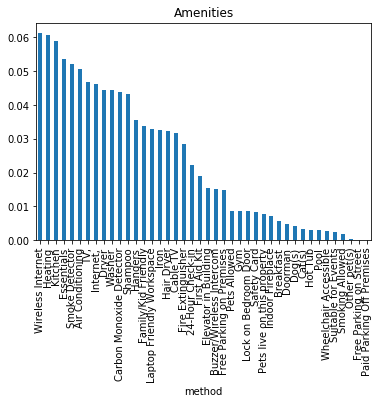

In [8]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of different types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

possible_vals = ["24-Hour Check-in", "Air Conditioning", "Breakfast", "Buzzer/Wireless Intercom", 
                 "Cable TV", "Carbon Monoxide Detector", "Cat(s)", "Dog(s)", "Doorman", ",Dryer",
                 "Elevator in Building", "Essentials", "Family/Kid Friendly", "Fire Extinguisher",
                 "First Aid Kit", "Free Parking on Premises", "Free Parking on Street", "Gym", "Hangers",
                 "Hair Dryer", "Heating", "Hot Tub", "Indoor Fireplace", "Internet,", "Iron", "Kitchen",
                 "Laptop Friendly Workspace", "Lock on Bedroom Door", "Other pet(s)", "Paid Parking Off Premises",
                 "Pets Allowed", "Pets live on this property", "Pool", "Safety Card", "Shampoo", "Smoke Detector",
                 "Smoking Allowed", "Suitable for Events", "TV,", "Washer", "Wheelchair Accessible",
                 "Wireless Internet"]

def clean_and_plot(df, title='Amenities', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['amenities'].value_counts().reset_index()
    study.rename(columns={'index': 'method', 'amenities': 'count'}, inplace=True)
    study_df = total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df)

### Check the distribution of the review scores rating

Text(0, 0.5, 'Frequency')

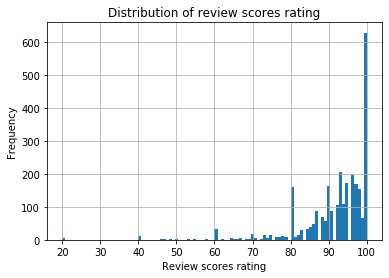

In [9]:
# Create a histogram of the review scores rating distribution
df['review_scores_rating'].hist(bins=100, range=(20, 100))
plt.title("Distribution of review scores rating")
plt.xlabel('Review scores rating')
plt.ylabel('Frequency')

## 3. Data preparation

In [10]:
df_prepared = df.copy() # Copy the original dataset into a new dataframe which is then changed step-by-step

### Correction of the price column
The price column contains unfortunately no number values but strings due to a leading "$" symbol and commas as 1000-seperators. Furthermore, the two decimal digits are always "0" and are, therefore, useless. Thus, these things are removed and the price is converted to int values. After that, the price distribution is plotted.

In [11]:
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[1:])) # Remove leading "$"
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[:-3])) # Remove decimal values (last 3 characters)
df_prepared['price'] = df_prepared['price'].map(lambda i: int(i.replace(",", ""))) # Remove commas and convert to int

Text(0, 0.5, 'Frequency')

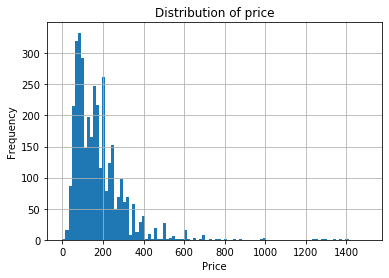

In [12]:
# Create a histogram of the price distribution
df_prepared['price'].hist(bins=100, range=(0, 1500))
plt.title("Distribution of price")
plt.xlabel('Price')
plt.ylabel('Frequency')

### Replacement of the amenities column by specific columns for each amenity
The amenities column is tricky, since it contains strings with all types of combinations of amenities. It is replaced by specific columns with boolean values.

In [13]:
df_prepared['24HourCheckin']          =df_prepared['amenities'].map(lambda i: "24-Hour Check-in" in i)
df_prepared['airConditioning']        =df_prepared['amenities'].map(lambda i: "Air Conditioning" in i)
df_prepared['breakfast']              =df_prepared['amenities'].map(lambda i: "Breakfast" in i)
df_prepared['buzzerWirelessIntercom'] =df_prepared['amenities'].map(lambda i: "Buzzer/Wireless Intercom" in i)
df_prepared['cableTV']                =df_prepared['amenities'].map(lambda i: "Cable TV" in i)
df_prepared['carbonMonoxideDetector'] =df_prepared['amenities'].map(lambda i: "Carbon Monoxide Detector" in i)
df_prepared['cats']                   =df_prepared['amenities'].map(lambda i: "Cat(s)" in i)
df_prepared['dogs']                   =df_prepared['amenities'].map(lambda i: "Dog(s)" in i)
df_prepared['doorman']                =df_prepared['amenities'].map(lambda i: "Doorman" in i)
df_prepared['dryer']                  =df_prepared['amenities'].map(lambda i: ",Dryer" in i) # Prohibits match in "Hair Dryer"
df_prepared['elevatorInBuilding']     =df_prepared['amenities'].map(lambda i: "Elevator in Building" in i)
df_prepared['essentials']             =df_prepared['amenities'].map(lambda i: "Essentials" in i)
df_prepared['familyKidFriendly']      =df_prepared['amenities'].map(lambda i: "Family/Kid Friendly" in i)
df_prepared['fireExtinguisher']       =df_prepared['amenities'].map(lambda i: "Fire Extinguisher" in i)
df_prepared['firstAidKit']            =df_prepared['amenities'].map(lambda i: "First Aid Kit" in i)
df_prepared['freeParkingOnPremises']  =df_prepared['amenities'].map(lambda i: "Free Parking on Premises" in i)
df_prepared['freeParkingOnStreet']    =df_prepared['amenities'].map(lambda i: "Free Parking on Street" in i)
df_prepared['gym']                    =df_prepared['amenities'].map(lambda i: "Gym" in i)
df_prepared['hangers']                =df_prepared['amenities'].map(lambda i: "Hangers" in i)
df_prepared['hairDryer']              =df_prepared['amenities'].map(lambda i: "Hair Dryer" in i)
df_prepared['heating']                =df_prepared['amenities'].map(lambda i: "Heating" in i)
df_prepared['hotTub']                 =df_prepared['amenities'].map(lambda i: "Hot Tub" in i)
df_prepared['indoorFireplace']        =df_prepared['amenities'].map(lambda i: "Indoor Fireplace" in i)
df_prepared['internet']               =df_prepared['amenities'].map(lambda i: "Internet," in i) # Prohibits match in "Cable TV"
df_prepared['iron']                   =df_prepared['amenities'].map(lambda i: "Iron" in i)
df_prepared['kitchen']                =df_prepared['amenities'].map(lambda i: "Kitchen" in i)
df_prepared['laptopFriendlyWorkspace']=df_prepared['amenities'].map(lambda i: "Laptop Friendly Workspace" in i)
df_prepared['lockOnBedroomDoor']      =df_prepared['amenities'].map(lambda i: "Lock on Bedroom Door" in i)
df_prepared['otherPets']              =df_prepared['amenities'].map(lambda i: "Other pet(s)" in i)
df_prepared['paidParkingOffPremises'] =df_prepared['amenities'].map(lambda i: "Paid Parking Off Premises" in i)
df_prepared['petsAllowed']            =df_prepared['amenities'].map(lambda i: "Pets Allowed" in i)
df_prepared['petsLiveOnThisProperty'] =df_prepared['amenities'].map(lambda i: "Pets live on this property" in i)
df_prepared['pool']                   =df_prepared['amenities'].map(lambda i: "Pool" in i)
df_prepared['safetyCard']             =df_prepared['amenities'].map(lambda i: "Safety Card" in i)
df_prepared['shampoo']                =df_prepared['amenities'].map(lambda i: "Shampoo" in i)
df_prepared['smokeDetector']          =df_prepared['amenities'].map(lambda i: "Smoke Detector" in i)
df_prepared['smokingAllowed']         =df_prepared['amenities'].map(lambda i: "Smoking Allowed" in i)
df_prepared['suitableForEvents']      =df_prepared['amenities'].map(lambda i: "Suitable for Events" in i)
df_prepared['tV']                     =df_prepared['amenities'].map(lambda i: "TV," in i) # Prohibits match in "Cable TV"
df_prepared['washer']                 =df_prepared['amenities'].map(lambda i: "Washer" in i)
df_prepared['wheelchairAccessible']   =df_prepared['amenities'].map(lambda i: "Wheelchair Accessible" in i)
df_prepared['wirelessInternet']       =df_prepared['amenities'].map(lambda i: "Wireless Internet" in i)

del df_prepared['amenities']


### Removing or impeding rows

In [14]:
print(df_prepared["review_scores_rating"].isnull().value_counts()) # Check number of empty fields in review scores rating

False    2772
True      813
Name: review_scores_rating, dtype: int64


29% of the review scores ratings contain no value, since the corresponding accommodations got no review yet. Since the goal is to predict this column later on, the missing rows will be removed.

In [15]:
df_reduced=df_prepared.dropna(subset=['review_scores_rating'], axis=0) # Remove rows with empty fields in review scores rating

print('The reduced dataset contains only', df_reduced.shape[0], 'rows.')

The reduced dataset contains only 2772 rows.


### Encoding categorial variables with ones and zeros
A number of interesting variables in the dataset are categorical ones: the neighborhood (the cleansed version), the property type, the room type, and the bed type. For these ones, extra columns with ones and zeros are added which can later on be used to create a linear model to predict the scores rating. To achieve this, the function from "Lesson 1 - Notebook + Quiz: Categorical Variables" is applied.

In [16]:
cat_df = df_reduced[['neighbourhood_cleansed', 'property_type', 'room_type']] # Create a DataFrame with 3 categorical columns
cat_df.head()

,neighbourhood_cleansed,property_type,room_type
1,Roslindale,Apartment,Private room
2,Roslindale,Apartment,Private room
3,Roslindale,House,Private room
4,Roslindale,House,Private room
5,Roslindale,Condominium,Private room


In [17]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [18]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df.columns

# Replace the categorical columns by dummy columns (ones and zeros) by using the function create_dummy_df
df_reduced_with_dummies = create_dummy_df(df_reduced, cat_cols_lst, dummy_na=False)

# 4. Modelling & Evaluation

### Question 1: Is there correlation between price and ratings?

Pearson correlation coefficient:
0.1056505948227876


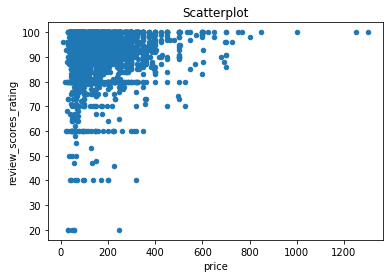

In [19]:
# Create a scatterplot for price vs review scores rating
df_reduced.plot.scatter(x='price', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_reduced['price'].corr(df_reduced['review_scores_rating']))

There seems to be a slight correleation between price and rating.

### Question 2: Are there differences in price and review scores rating between different neighbourhoods?

In [20]:
# Group neighbourhoods and calculate their mean price and review scores rating
df_neighbourhood_relations=pd.DataFrame()
df_neighbourhood_relations['price']=df_reduced.groupby('neighbourhood_cleansed').mean()['price'].sort_values(ascending=False)
df_neighbourhood_relations['review_scores_rating']=df_reduced.groupby('neighbourhood_cleansed').mean()['review_scores_rating'].sort_values(ascending=False)
df_neighbourhood_relations.head()

,price,review_scores_rating
neighbourhood_cleansed,,
South Boston Waterfront,263.810345,94.431034
Bay Village,250.875000,93.000000
Leather District,242.666667,98.333333
Chinatown,239.195122,92.121951
Back Bay,237.164557,91.531646


Pearson correlation coefficient:
0.3176659073286343


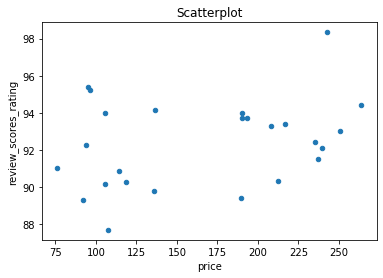

In [21]:
# Create a scatterplot for price vs review scores rating based on previously calculated means for neighbourhoods
df_neighbourhood_relations.plot.scatter(x='price', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_neighbourhood_relations['price'].corr(df_neighbourhood_relations['review_scores_rating']))

It is not analyzed in more detail here, but it seems that neighbourhoods with a higher rating also have a higher mean price and vice versa.

### Question 3: Is there correlation between the number of reviews and the review scores rating?

Pearson correlation coefficient:
0.02277785222784338


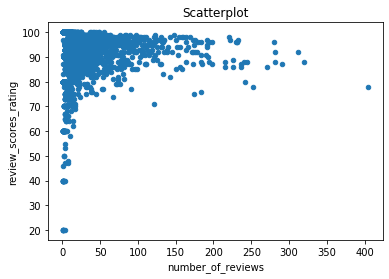

In [22]:
# Create a scatterplot for number of reviews vs review scores rating
df_reduced.plot.scatter(x='number_of_reviews', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_reduced['review_scores_rating'].corr(df_reduced['number_of_reviews']))

The scatterplot shows an interesting pattern, however, the correlation coefficient not indicates a relation between the two measures.

### Question 4: Is there a relation between amenities and rating?

In the next step, a linear model is build based on the new amenities columns with the goal to predict the review scores rating.

In [23]:
# Consider only amenity variables
X = df_reduced[['24HourCheckin', 'airConditioning', 'breakfast', 'buzzerWirelessIntercom', 'cableTV', 
                'carbonMonoxideDetector', 'cats', 'dogs', 'doorman', 'dryer', 'elevatorInBuilding',
                'essentials', 'familyKidFriendly', 'fireExtinguisher', 'firstAidKit', 'freeParkingOnPremises',
                'freeParkingOnStreet', 'gym', 'hangers', 'hairDryer', 'heating', 'hotTub', 'indoorFireplace',
                'internet', 'iron', 'kitchen', 'laptopFriendlyWorkspace', 'lockOnBedroomDoor', 'otherPets',
                'paidParkingOffPremises', 'petsAllowed', 'petsLiveOnThisProperty', 'pool', 'safetyCard',
                'shampoo', 'smokeDetector', 'smokingAllowed', 'suitableForEvents', 'tV', 'washer',
                'wheelchairAccessible', 'wirelessInternet']]
y = df_reduced['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test =  r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value is:', r2_test)

The R^2 value is: 0.027724779654798914


Now the coefficients of the model are listed. However, since the correlation is weak, there seems to be no deeper meaning behind the values.

In [24]:
for i in range(0, len(X.columns)):
    print(X.columns[i], ":", lm_model.coef_[i])

24HourCheckin : -0.340121047954179
airConditioning : 2.7317876062824884
breakfast : 1.3042176274479924
buzzerWirelessIntercom : -0.21038729129751121
cableTV : 0.4204153034957165
carbonMonoxideDetector : 0.6443822389804092
cats : -0.3133495178777601
dogs : 0.22930724138266922
doorman : 2.190397499365159
dryer : -1.5140851827550923
elevatorInBuilding : 0.9935627333454234
essentials : 1.58600568194622
familyKidFriendly : -0.9531499976138134
fireExtinguisher : 1.211068584706747
firstAidKit : 0.5802201174048289
freeParkingOnPremises : 0.6288871207631401
freeParkingOnStreet : -1.7908374457306395
gym : -2.4604631630812253
hangers : 0.4097147576601878
hairDryer : 0.26680120795864154
heating : 0.5456413467563991
hotTub : -1.8489787203631416
indoorFireplace : 0.8199489494794266
internet : -0.7031957480463981
iron : 0.013887505576841064
kitchen : -1.7216076334167185
laptopFriendlyWorkspace : 0.6485579584285656
lockOnBedroomDoor : -0.3371040656833359
otherPets : 0.6796447307018015
paidParkingOffPr

### Question 5: Is there a way to predict the review scores rating based on amenities and price?

Now, also the price column is added to build the model (since question 1 and 2 showed slight correlation of price with review scores rating, the price has been added).

In [25]:
# Consider only amenity variables and price
X = df_reduced[['price', '24HourCheckin', 'airConditioning', 'breakfast', 'buzzerWirelessIntercom', 'cableTV', 
                'carbonMonoxideDetector', 'cats', 'dogs', 'doorman', 'dryer', 'elevatorInBuilding',
                'essentials', 'familyKidFriendly', 'fireExtinguisher', 'firstAidKit', 'freeParkingOnPremises',
                'freeParkingOnStreet', 'gym', 'hangers', 'hairDryer', 'heating', 'hotTub', 'indoorFireplace',
                'internet', 'iron', 'kitchen', 'laptopFriendlyWorkspace', 'lockOnBedroomDoor', 'otherPets',
                'paidParkingOffPremises', 'petsAllowed', 'petsLiveOnThisProperty', 'pool', 'safetyCard',
                'shampoo', 'smokeDetector', 'smokingAllowed', 'suitableForEvents', 'tV', 'washer',
                'wheelchairAccessible', 'wirelessInternet']]
y = df_reduced['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test =  r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value is:', r2_test)

The R^2 value is: 0.028457249334719603


In the next step a function from the file AllTogether.py from the Lesson 1 materials is applied to create subsets with different number of features to create a similar plot as in "Lesson 1 - Notebook + Quiz: Putting It All Together".

In [26]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

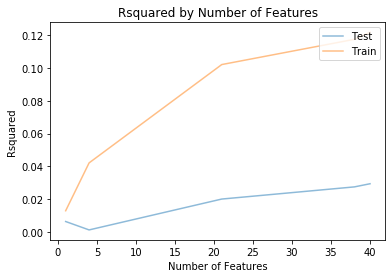

In [27]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

The result is weak. It seems to be not useful to predict the review scores rating based on price and amenities.

### For comparison: Predict the price based on amenities and review scores rating

In [28]:
# Consider only amenity variables and price
X = df_reduced[['review_scores_rating', '24HourCheckin', 'airConditioning', 'breakfast', 'buzzerWirelessIntercom', 'cableTV', 
                'carbonMonoxideDetector', 'cats', 'dogs', 'doorman', 'dryer', 'elevatorInBuilding',
                'essentials', 'familyKidFriendly', 'fireExtinguisher', 'firstAidKit', 'freeParkingOnPremises',
                'freeParkingOnStreet', 'gym', 'hangers', 'hairDryer', 'heating', 'hotTub', 'indoorFireplace',
                'internet', 'iron', 'kitchen', 'laptopFriendlyWorkspace', 'lockOnBedroomDoor', 'otherPets',
                'paidParkingOffPremises', 'petsAllowed', 'petsLiveOnThisProperty', 'pool', 'safetyCard',
                'shampoo', 'smokeDetector', 'smokingAllowed', 'suitableForEvents', 'tV', 'washer',
                'wheelchairAccessible', 'wirelessInternet']]
y = df_reduced['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test =  r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value is:', r2_test)

The R^2 value is: 0.2743361634339214


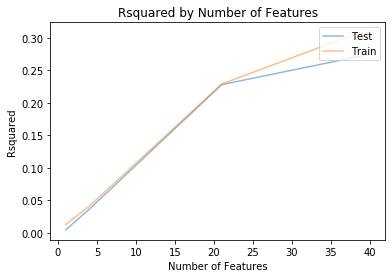

In [29]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

After exchanging price and review scores rating in order to predict the price by review scores rating and amenities, the results are much better also for the test data. Thus, it shows that the general approach works. In some terms, the price can be predicted. However, regarding the question above, the result is negative.

A more detailled discussion can be found in my corresponding [blog post](https://mirods.github.io).